# Audio Spoofing Detection Notebook

This notebook aims to detect spoofed audio using various machine learning models. It covers data loading, preprocessing, model training, evaluation, and plotting.

In [3]:
# Setup and Initial Imports
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Add the project root folder to PYTHONPATH
sys.path.append(os.path.abspath('..'))

## Import Machine Learning Libraries

In this cell, we import the necessary libraries for machine learning and data processing.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, det_curve
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

## Define File Paths

Define the paths for the processed features and protocol file. Make sure to adjust these paths as needed.

In [5]:
features_path = '../data/processed/filterbanks_features.pkl'
protocol_path = '../data/raw/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'

## Load Features

Load the feature data from the pickle file.

In [6]:
with open(features_path, 'rb') as f:
    data = pickle.load(f)

## Read Protocol File

Define a function to read the protocol file, which maps audio files to labels, and load the DataFrame.

In [7]:
def read_cm_protocol(filepath: str) -> pd.DataFrame:
    """
    Reads the CM protocol file and returns a DataFrame.
    
    Args:
        filepath (str): Path to the protocol file.
    
    Returns:
        pd.DataFrame: DataFrame with speaker_id, audio_file, system_id, and key.
    """
    column_names = ["speaker_id", "audio_file", "system_id", "unused", "key"]
    df = pd.read_csv(filepath, sep=' ', names=column_names, index_col=False)
    df.drop(columns=["unused"], inplace=True)
    return df

protocol_df = read_cm_protocol(protocol_path)
print("Protocol Data (first 5 rows):")
print(protocol_df.head())

Protocol Data (first 5 rows):
  speaker_id    audio_file system_id       key
0    LA_0079  LA_T_1138215         -  bonafide
1    LA_0079  LA_T_1271820         -  bonafide
2    LA_0079  LA_T_1272637         -  bonafide
3    LA_0079  LA_T_1276960         -  bonafide
4    LA_0079  LA_T_1341447         -  bonafide


## Create DataFrame for Features and Labels

Create a DataFrame where each row contains a file name and its corresponding features. Label 1 represents "spoof" and 0 represents "bonafide".

In [8]:
label_dict = dict(zip(protocol_df['audio_file'], protocol_df['key']))
df_features = pd.DataFrame(
    [(d['file'], *d['features']) for d in data],
    columns=["file"] + [f"feature_{i}" for i in range(len(data[0]['features']))]
)

df_features["label"] = df_features["file"].apply(
    lambda x: 1 if label_dict.get(x.replace('.flac', '').replace('.wav', ''), 'bonafide') == 'spoof' else 0
)

print("Features DataFrame (first 5 rows):")
print(df_features.head())

Features DataFrame (first 5 rows):
                file  feature_0  feature_1  feature_2  feature_3  feature_4  \
0  LA_T_1000137.flac   0.000010   0.000022   0.000072   0.001275   0.046314   
1  LA_T_1000406.flac   0.000011   0.000016   0.000036   0.000889   0.011094   
2  LA_T_1000648.flac   0.000003   0.000003   0.000006   0.000099   0.001488   
3  LA_T_1000824.flac   0.000017   0.000050   0.000262   0.011847   0.271454   
4  LA_T_1001074.flac   0.000002   0.000004   0.000015   0.000821   0.015475   

   feature_5  feature_6  feature_7  feature_8  ...  feature_631  feature_632  \
0   0.565488   2.776286   6.029241  10.804525  ...     0.000097     0.000081   
1   0.033539   0.144185   1.887749   7.177183  ...     0.000002     0.000002   
2   0.003842   0.004142   0.003567   0.004978  ...     0.000042     0.000038   
3   2.040871   4.335693   3.998420   1.990429  ...     0.000004     0.000006   
4   0.060690   0.101386   0.129564   0.271895  ...     0.000003     0.000002   

   featur

## Data Exploration

Display the distribution of labels to verify the balance of the dataset.

In [9]:
label_dist = df_features['label'].value_counts().rename(index={0: 'bonafide', 1: 'spoof'})
label_pct = df_features['label'].value_counts(normalize=True).mul(100).rename(index={0: 'bonafide', 1: 'spoof'}).round(2)
df_label_summary = pd.DataFrame({'Count': label_dist, 'Percent (%)': label_pct})
print("Label Distribution:")
print(df_label_summary)

Label Distribution:
          Count  Percent (%)
label                       
spoof     22800        89.83
bonafide   2580        10.17


## Data Preprocessing

Separate the features (X) and labels (y), standardize the features, and split the data into training and testing sets.

In [10]:
X = df_features.drop(columns=["file", "label"]).values
y = df_features["label"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Dataset Statistics

Define a function to display the label distribution in the training and testing sets.

In [11]:
def dataset_stats(y_train: np.ndarray, y_test: np.ndarray) -> None:
    """
    Prints the distribution of labels for training and testing sets.
    
    Args:
        y_train (np.ndarray): Array of training labels.
        y_test (np.ndarray): Array of testing labels.
    """
    train_dist = pd.Series(y_train).value_counts().rename(index={0: 'bonafide', 1: 'spoof'})
    test_dist = pd.Series(y_test).value_counts().rename(index={0: 'bonafide', 1: 'spoof'})
    train_pct = pd.Series(y_train).value_counts(normalize=True).mul(100).rename(index={0: 'bonafide', 1: 'spoof'}).round(2)
    test_pct = pd.Series(y_test).value_counts(normalize=True).mul(100).rename(index={0: 'bonafide', 1: 'spoof'}).round(2)
    
    df_stats = pd.DataFrame({
        'Train Count': train_dist, 'Train %': train_pct,
        'Test Count': test_dist, 'Test %': test_pct
    })
    print("\nDataset distribution after split:")
    print(df_stats)

dataset_stats(y_train, y_test)


Dataset distribution after split:
          Train Count  Train %  Test Count  Test %
spoof           18233     89.8        4567   89.97
bonafide         2071     10.2         509   10.03


## Define, Train, and Evaluate Models

Define a dictionary of models, then train and evaluate each one. For each model, we calculate the training time, accuracy, confusion matrix, and Equal Error Rate (EER).


Training models...


Models:   0%|          | 0/6 [00:00<?, ?it/s]


Random Forest:
Training time: 31.20 seconds
Accuracy: 0.9963
Confusion Matrix:
 [[ 493   16]
 [   3 4564]]
EER: 0.0039
Model saved to Random_Forest.pkl
Metrics for Random Forest appended to model_metrics.csv


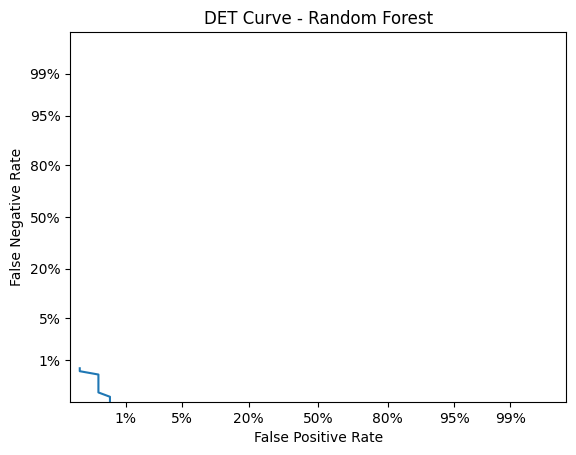

Models:  17%|█▋        | 1/6 [00:31<02:37, 31.51s/it]


Decision Tree:
Training time: 18.30 seconds
Accuracy: 0.9823
Confusion Matrix:
 [[ 469   40]
 [  50 4517]]
EER: 0.0786
Model saved to Decision_Tree.pkl
Metrics for Decision Tree appended to model_metrics.csv


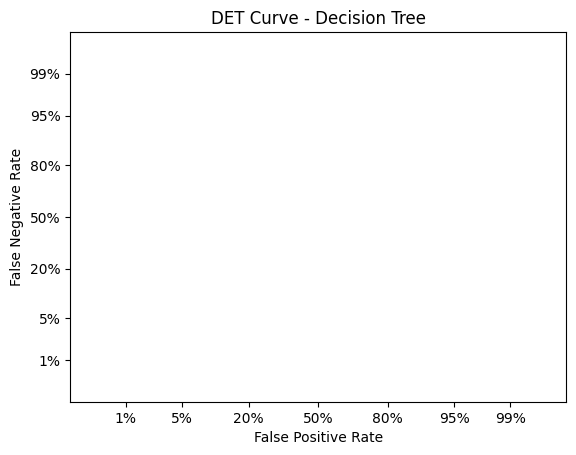

Models:  33%|███▎      | 2/6 [00:49<01:35, 23.84s/it]


Logistic Regression:
Training time: 21.49 seconds
Accuracy: 0.9403
Confusion Matrix:
 [[ 290  219]
 [  84 4483]]
EER: 0.0864
Model saved to Logistic_Regression.pkl
Metrics for Logistic Regression appended to model_metrics.csv


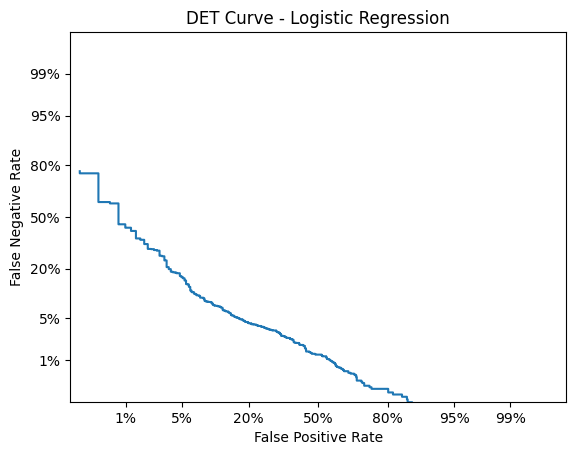

Models:  50%|█████     | 3/6 [01:11<01:08, 22.89s/it]


LightGBM:
[LightGBM] [Info] Number of positive: 18233, number of negative: 2071
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163200
[LightGBM] [Info] Number of data points in the train set: 20304, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.898000 -> initscore=2.175202
[LightGBM] [Info] Start training from score 2.175202
Training time: 2.28 seconds
Accuracy: 0.9992
Confusion Matrix:
 [[ 507    2]
 [   2 4565]]
EER: 0.0020
Model saved to LightGBM.pkl
Metrics for LightGBM appended to model_metrics.csv


/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/vicosbe/victo/audio_symbolic_regression/audio_symbolic_regression_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


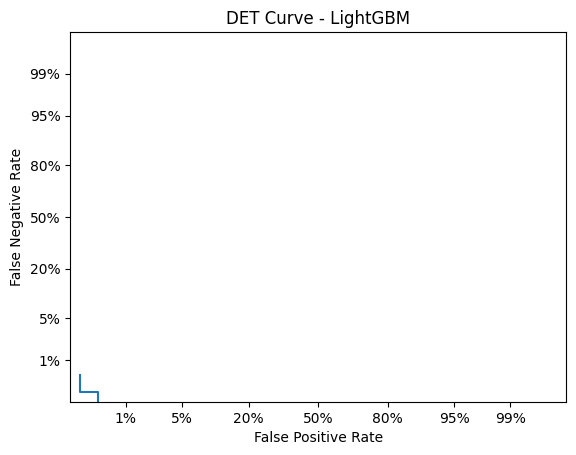

Models:  67%|██████▋   | 4/6 [01:14<00:29, 14.82s/it]


MLP (Neural Network):
Training time: 11.94 seconds
Accuracy: 0.9817
Confusion Matrix:
 [[ 455   54]
 [  39 4528]]
EER: 0.0334
Model saved to MLP_Neural_Network.pkl
Metrics for MLP (Neural Network) appended to model_metrics.csv


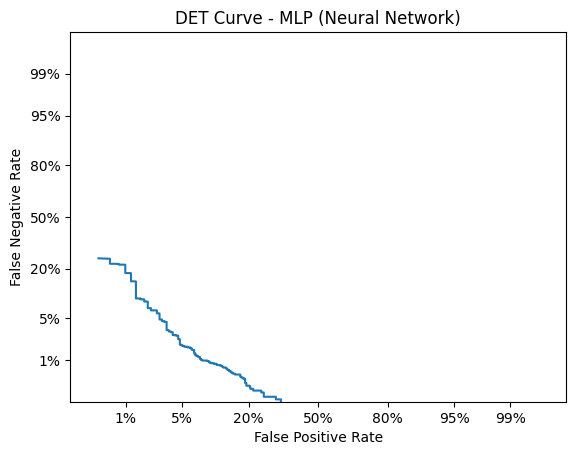

Models:  83%|████████▎ | 5/6 [01:26<00:13, 13.86s/it]


SVM:
Training time: 40.60 seconds
Accuracy: 0.9257
Confusion Matrix:
 [[ 140  369]
 [   8 4559]]
EER: 0.1061
Model saved to SVM.pkl
Metrics for SVM appended to model_metrics.csv


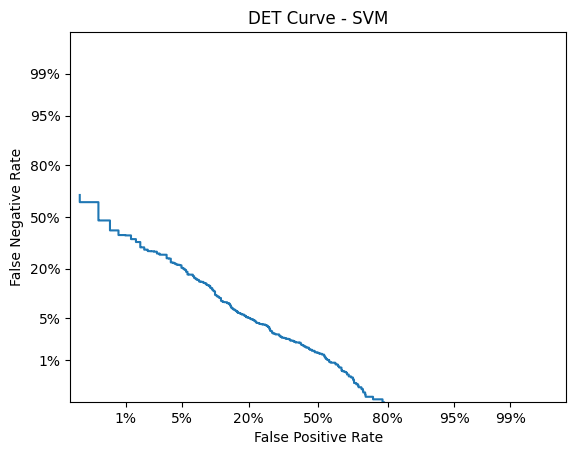

Models: 100%|██████████| 6/6 [02:25<00:00, 24.21s/it]


In [12]:
# Define models dictionary
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LightGBM": LGBMClassifier(random_state=42),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "SVM": SVC(random_state=42)
}

# CSV file to store metrics
csv_file = "model_metrics.csv"

# If the CSV file doesn't exist, create it with the header.
if not os.path.exists(csv_file):
    header_df = pd.DataFrame(columns=["Model", "Training Time (sec)", "Accuracy", "EER"])
    header_df.to_csv(csv_file, index=False)

print("\nTraining models...")

for name, model in tqdm(models.items(), desc="Models"):
    print(f"\n{name}:")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predict on test set and compute accuracy
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Accuracy: {acc:.4f}")
    
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Calculate Equal Error Rate (EER)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)
    
    fpr, fnr, thresholds = det_curve(y_test, y_scores)
    idx = np.nanargmin(np.absolute(fnr - fpr))
    eer_threshold = thresholds[idx]
    eer = fpr[idx]
    print(f"EER: {eer:.4f}")
    
    # Save the trained model as a .pkl file
    model_filename = f"{name.replace(' ', '_').replace('(', '').replace(')', '')}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_filename}")
    
    # Prepare metrics dictionary for the current model
    metrics = {
         "Model": name,
         "Training Time (sec)": round(train_time, 2),
         "Accuracy": round(acc, 4),
         "EER": round(eer, 4)
    }
    
    # Immediately save the metrics for this model by appending to the CSV file
    row_df = pd.DataFrame([metrics])
    row_df.to_csv(csv_file, mode="a", header=False, index=False)
    print(f"Metrics for {name} appended to {csv_file}")
    
    # Optional: Plot the DET curve (uncomment to enable)
    from sklearn.metrics import DetCurveDisplay
    display = DetCurveDisplay(fpr=fpr, fnr=fnr)
    display.plot()
    plt.title(f"DET Curve - {name}")
    plt.show()
